# Perform object segmentation with pollen-vision

Learn how to perform object segmentation with the pollen-vision library, using the MobileSAM model.

MobileSAM is a lighter version of SAM, a segmentation model developed by Meta AI.

💡 In this notebook, we assume that you have already checked the notebook dedicated to zero shot object detection as we will also perform object detection here.

![Object segmentation from Reachy's egocentric view](gif/reachy_kitchen_masks.gif)

## A word on SAM and Mobile SAM

SAM stands for Segment Anything Model. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training developed by Meta AI. With SAM, you can just give a point to the model to predict the mask for a single object of interest.

In 2023, researchers from Kyung Hee University developed MobileSAM, a lighter version of SAM which allows SAM to be run on mobile devices. In pollen-vison we are using the implementation of MobileSAM from its authors. Check the [MobileSAM paper](https://arxiv.org/pdf/2306.14289.pdf), its [GitHub repository](https://github.com/ChaoningZhang/MobileSAM) and the [orginal SAM paper](https://arxiv.org/pdf/2304.02643.pdf) for more information. 

Credits to Chaoning Zhang et al. from Kyung Hee University and to Alexander Kirillov et al. from Meta AI for developing this and making it open source!

In [1]:
import numpy as np
from PIL import Image

from pollen_vision.vision_models.object_segmentation import MobileSamWrapper

In [2]:
object_segmentation_wrapper = MobileSamWrapper()

Import the image you want to perform the inference on. 

Here we will take one of the test image of the project. We placed the demo images in sub folder in the images folder. Each subfolder is for a different situation where we recorded what Reachy was doing using teleoperation. Feel free to try with your own image!

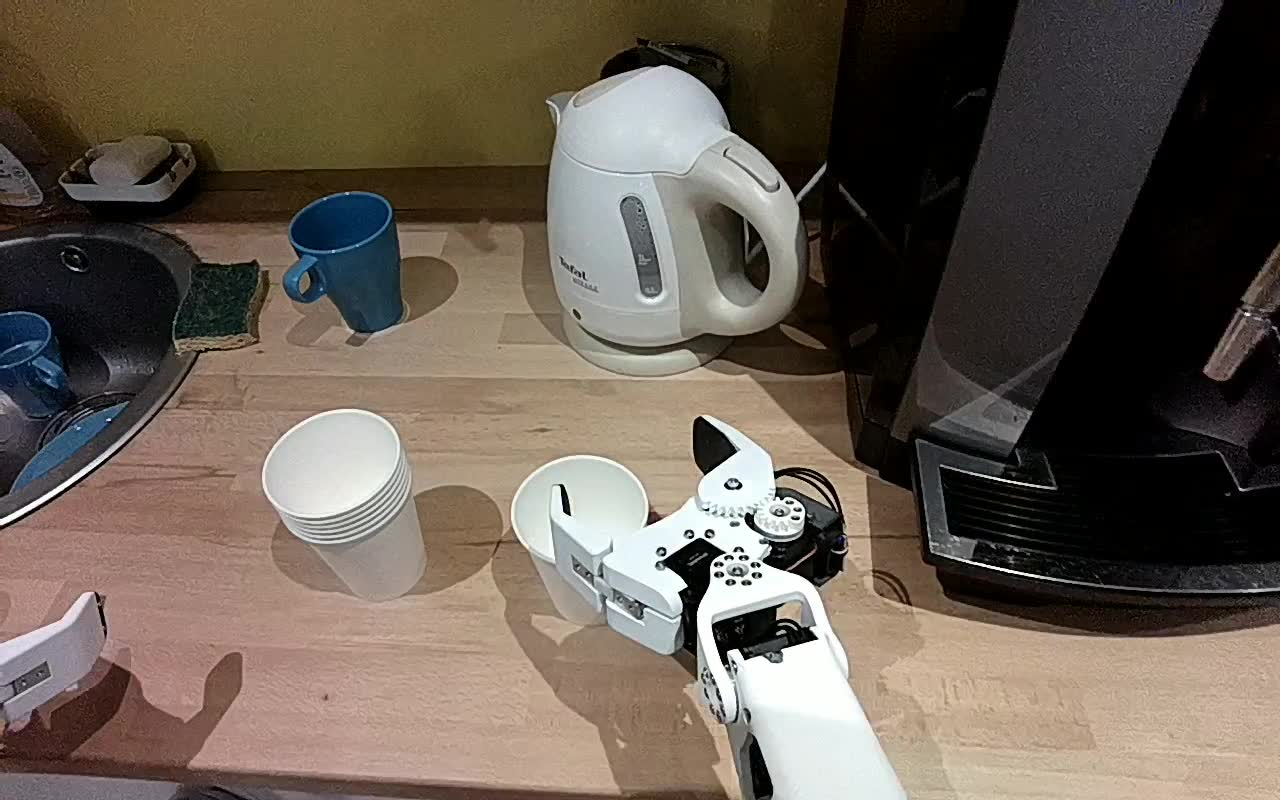

In [3]:
img = Image.open('images/serving-cup/serving_cup_01.jpg')
img

This photo is taken from the point of view of our Reachy robot.

Let's perform object segmentation on objects Reachy could grasp.

## First: object detection

To obtain the segmentation, we first need to do object detection in the image to give inputs to MobileSAM. MobileSAM (and SAM as well) takes either a point, a list of points or a bounding box of an object to perform the segmentation. We chose in our wrapper to keep only the approach with the bounding boxes. So let's get bounding boxes for objects Reachy could grasp, using the OwlViT wrapper.

In [4]:
from pollen_vision.vision_models.object_detection import OwlVitWrapper

object_detection_wrapper = OwlVitWrapper()

If you chose your own image, replace the *candidate_labels* argument with your own list of objects candidates.

In [5]:
predictions = object_detection_wrapper.infer(im=np.array(img), candidate_labels=["blue mug", "paper cup", "kettle", "sponge"], detection_threshold=0.12)
predictions

[{'score': 0.2898854613304138,
  'label': 'blue mug',
  'box': {'xmin': 277, 'ymin': 194, 'xmax': 412, 'ymax': 343}},
 {'score': 0.18099206686019897,
  'label': 'sponge',
  'box': {'xmin': 167, 'ymin': 256, 'xmax': 269, 'ymax': 352}},
 {'score': 0.15593598783016205,
  'label': 'kettle',
  'box': {'xmin': 539, 'ymin': 46, 'xmax': 821, 'ymax': 380}},
 {'score': 0.13799072802066803,
  'label': 'paper cup',
  'box': {'xmin': 258, 'ymin': 404, 'xmax': 431, 'ymax': 600}}]

We can extract the bounding boxes from the predictions, we will need them as input for the segmentation.

In [6]:
from pollen_vision.vision_models.utils import get_bboxes

bboxes = get_bboxes(predictions)

N.B.: the format returned for the bounding boxes is *[xmin, ymin, xmax, ymax]*

### Visualize object detections

You can visualize easliy the predictions of the object detection model with the *Annotator* class from utils.

In [7]:
from pollen_vision.vision_models.utils import Annotator

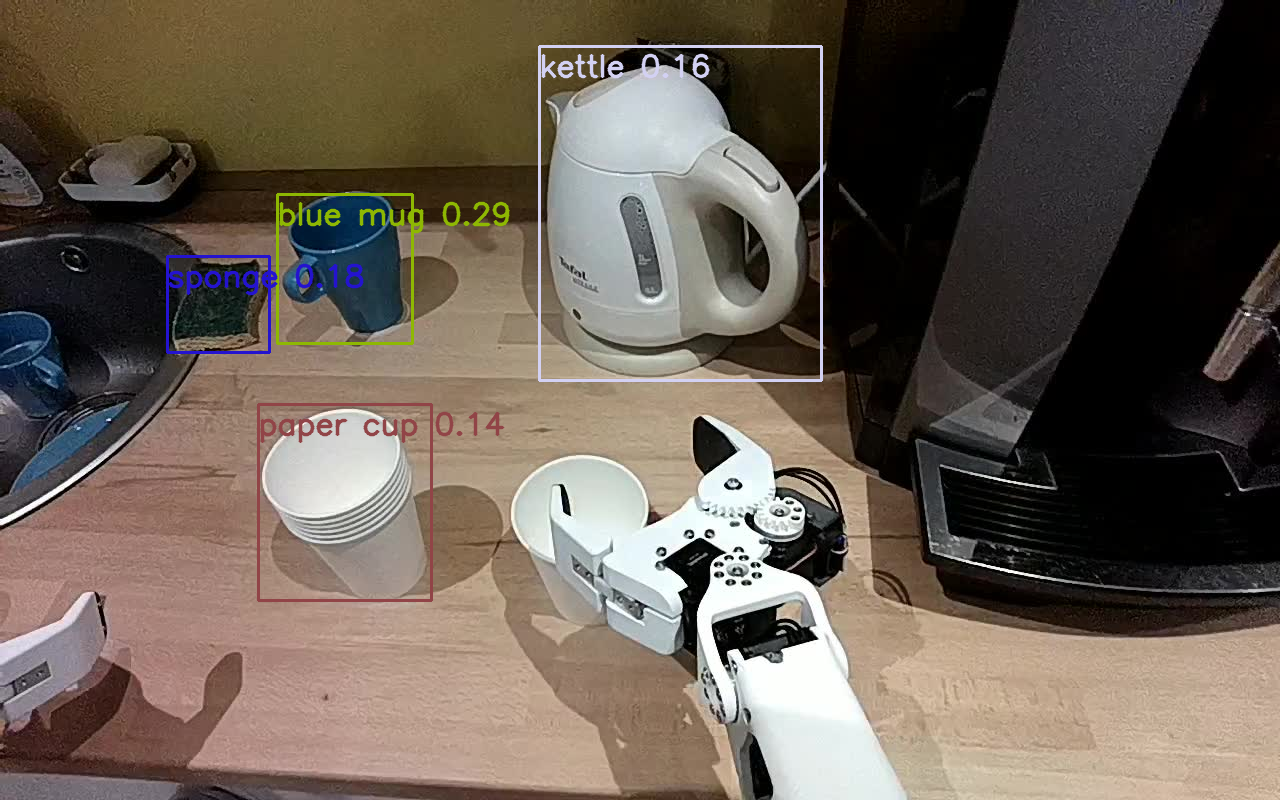

In [8]:
annotator = Annotator()

img_annotated = annotator.annotate(im=img, detection_predictions=predictions)
Image.fromarray(img_annotated)

## At last, the segmentation!

Now that we have the bounding boxes for the objects we are interested in, we can use our SAM wrapper defined earlier to obtain the segmentation of each object.

In [9]:
masks = object_segmentation_wrapper.infer(im=img, bboxes=bboxes)

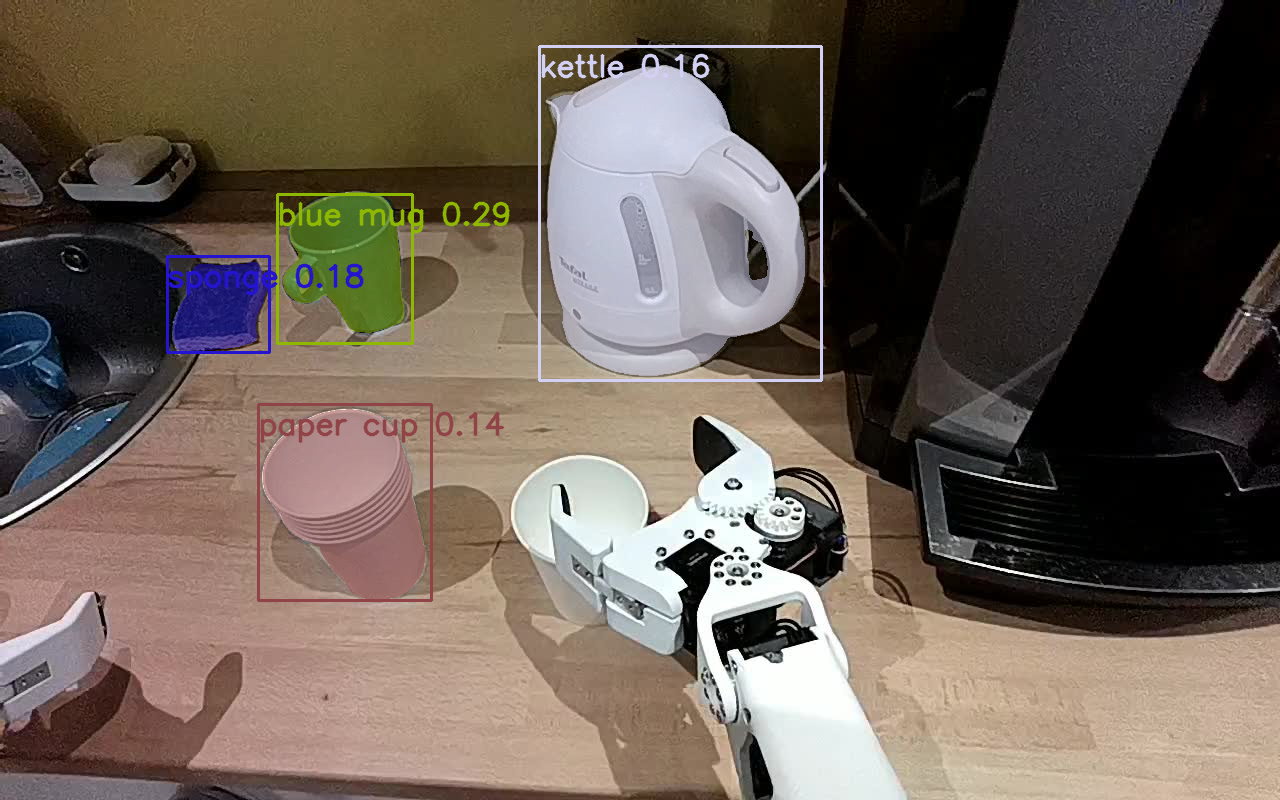

In [10]:
img_annotated = annotator.annotate(im=img, detection_predictions=predictions, masks=masks)
Image.fromarray(img_annotated)